In [1]:
## Import necessary packages
import numpy as np
import pandas as pd
from statistics import mean
from statistics import pstdev
from scipy import stats
import csv
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
### This section of code extracts and normalizes mutability scores from ###
### the dataset. ###

# Extract mutability scores sheet from dataset and save as a pandas 
# DataFrame. Excel file contains multiple sheets of which the mutability
# scores is contains two columns: amino acid position and mutability score
mutability_scores = pd.read_excel(io=
                                  'Spencer_et_al_2017_Cas9_mutagenesis.xlsx',
                                   sheet_name='Mutability Scores')

# Convert DataFrame to list and calculate mean and 
# standard deviation (population) of mutability scores
mutability_scores_list = mutability_scores['Mutability Score'].tolist()
mean_mut_score = mean(mutability_scores_list)
stdev_mut_score = pstdev(mutability_scores_list)

# Normalize mutability scores using mean and stdev
for index, row in mutability_scores.iterrows():
    normalized_mutability_score = (row[1] - 
                                   mean_mut_score)/stdev_mut_score
    mutability_scores = mutability_scores.replace(row[1], 
                                                  normalized_mutability_score)

In [3]:
### This section of code extracts the domains of the amino acids, which was ###
### not provided in the mutability scores sheet used above. ###
### "All Count Data" contains many columns of data, of which only domains ###
### and their respective amino acids are needed. ###

# Extract all the data from the dataset and save to a DataFrame
df1 = pd.read_excel(io='Spencer_et_al_2017_Cas9_mutagenesis.xlsx',
                   sheet_name='All Count Data')

# Drop duplicates ("All Count Data" contains all mutations made at each
# amino acid position which is used to calculate the final mutability scores)
df1.drop_duplicates(subset=['AA Position'], inplace=True)

# Create series of amino acid positions and their domains
s1 = pd.Series(df1['AA Position'], name='AA Position')
s2 = pd.Series(df1['Domain'], name='Domain')

# Concatenate series into a DataFrame 
aa_domains = pd.concat([s1,s2], axis=1)

In [4]:
# Merge amino acids, domains, and mutability scores into a new DataFrame
aa_domains_mutability = pd.merge(aa_domains, mutability_scores, 
                                 on=['AA Position'])

# Drop any rows generated for which there is no data
aa_domains_mutability = aa_domains_mutability.dropna()

# Save DataFrame into an excel sheet
aa_domains_mutability.to_excel('AminoAcids_Domains_Mutability.xlsx')

In [5]:
### This section of code extracts the network scores generated by the ###
### structural network conversion of Cas9. ###

# Open excel sheet of network scores (change this file based on what network
# representation you wish to use) and save amino acids and network scores
# into DataFrame
with open('FinalSum_Cas9RNP_NoNodeEdgeBetweenness') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter='\t')
    aa_network_scores = pd.DataFrame(csv_reader, 
                                     columns=['AA Position','Network Score'])
    
# Drop network scores generated for the nucleic acid ligands since mutational
# analysis is done on amino acids alone
aa_network_scores = aa_network_scores[aa_network_scores['Network Score'] 
                                      != 'NA']

# Convert network scores to float and sort DataFrame ascending order
aa_network_scores['Network Score'] = aa_network_scores[
    'Network Score'].astype(float)
aa_network_scores = aa_network_scores.sort_values(by=['Network Score'])

# Network representation outputs amino acids as both position and
# name, so loop through and remove letters from the amino acids,
# i.e. remove the names
for aa in aa_network_scores['AA Position']:
    aa_new = int(re.sub('\D', '', aa))
    aa_network_scores = aa_network_scores.replace(to_replace=aa, value=aa_new)

# Sort DataFrame in ascending order of amino acid position
aa_network_scores = aa_network_scores.sort_values(by=['AA Position'])

# Save DataFrame as an excel sheet
aa_network_scores.to_excel('AminoAcids_NetworkScores.xlsx')

In [6]:
# Merge the two dataframes and rearrange the columns in order of amino acid
# position, domain, network score, and mutability score
aa_domains_network_mutability = pd.merge(aa_network_scores, 
                                         aa_domains_mutability, 
                                         on=['AA Position'])
columns_swap = ['AA Position','Domain','Network Score','Mutability Score']
aa_domains_network_mutability = aa_domains_network_mutability.reindex(
    columns=columns_swap)

# Save compiled DataFrame to an excel sheet
aa_domains_network_mutability.to_excel('Mutability_NetworkScores.xlsx')

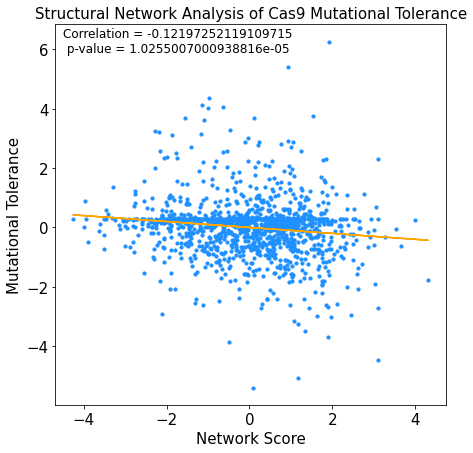

In [7]:
### This section of code generates the linear regression between ###
### the network scores and mutational tolerances and calculates ###
### the Spearman's rank correlation coefficient and significance of ###
### the regression. Then, a scatter plot of the data is generated ###
### including the linear regression line and statistical analysis results. ###

# Generate figure
fig = plt.figure(figsize = (7,7))

# Get all network scores and mutability scores and plot them
x_vals = aa_domains_network_mutability.loc[:,'Network Score']
y_vals = aa_domains_network_mutability.loc[:,'Mutability Score']
plt.scatter(x_vals, y_vals, s=10, color='dodgerblue')

# Generate the slope and y-intercept of the line of best fit and plot it
m, b = np.polyfit(x_vals, y_vals, 1)
plt.plot(x_vals, m*x_vals + b, color='orange')

# Add title, x- and y-axis labels, and adjust tick mark sizes
plt.xlabel('Network Score', fontsize = 15)
plt.ylabel('Mutational Tolerance', fontsize = 15)
plt.title('Structural Network Analysis of Cas9 Mutational Tolerance', 
          fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

# Calculate Spearman's rank correlation coefficient and p-value, then add it
# to the figure
model_x = np.array(x_vals).reshape((-1,1))
model_y = np.array(y_vals)
correlation, pvalue = stats.spearmanr(model_x, model_y)
fig_text = 'Correlation = {} \n p-value = {}'.format(correlation,pvalue)
plt.text(-4.5,5.9, fig_text, fontsize = 12)
plt.show()

# Save figure to jpg
fig.savefig('Structural Network Analysis.jpg', bbox_inches='tight')

In [8]:
# Domain_scorer defines a function that takes a DataFrame and a domain name
# and returns only the network scores and mutability scores.
# Inputs:
# df, a DataFrame
# domain_name, the name of the domain for which you want network scores
#              and mutability scores
# Assumptions:
# DataFrame has columns named 'Domain', Network Score', and 'Mutability Score'
# domain_name is a domain that exists in the DataFrame
def domain_scorer(df, domain_name):
    rows = df[df['Domain'].str.contains(domain_name)]
    x_vals = rows.loc[:,'Network Score']
    y_vals = rows.loc[:,'Mutability Score']
    
    return x_vals, y_vals

In [9]:
# Get the network scores and mutability scores for all the domains of Cas9
RuvC_x_vals, RuvC_y_vals = domain_scorer(aa_domains_network_mutability, 'RuvC')
BH_x_vals, BH_y_vals = domain_scorer(aa_domains_network_mutability, 'BH')
Rec1_x_vals, Rec1_y_vals = domain_scorer(aa_domains_network_mutability, 'Rec1')
Rec2_x_vals, Rec2_y_vals = domain_scorer(aa_domains_network_mutability, 'Rec2')
HNH_x_vals, HNH_y_vals = domain_scorer(aa_domains_network_mutability, 'HNH')
PI_x_vals, PI_y_vals = domain_scorer(aa_domains_network_mutability, 'PI')

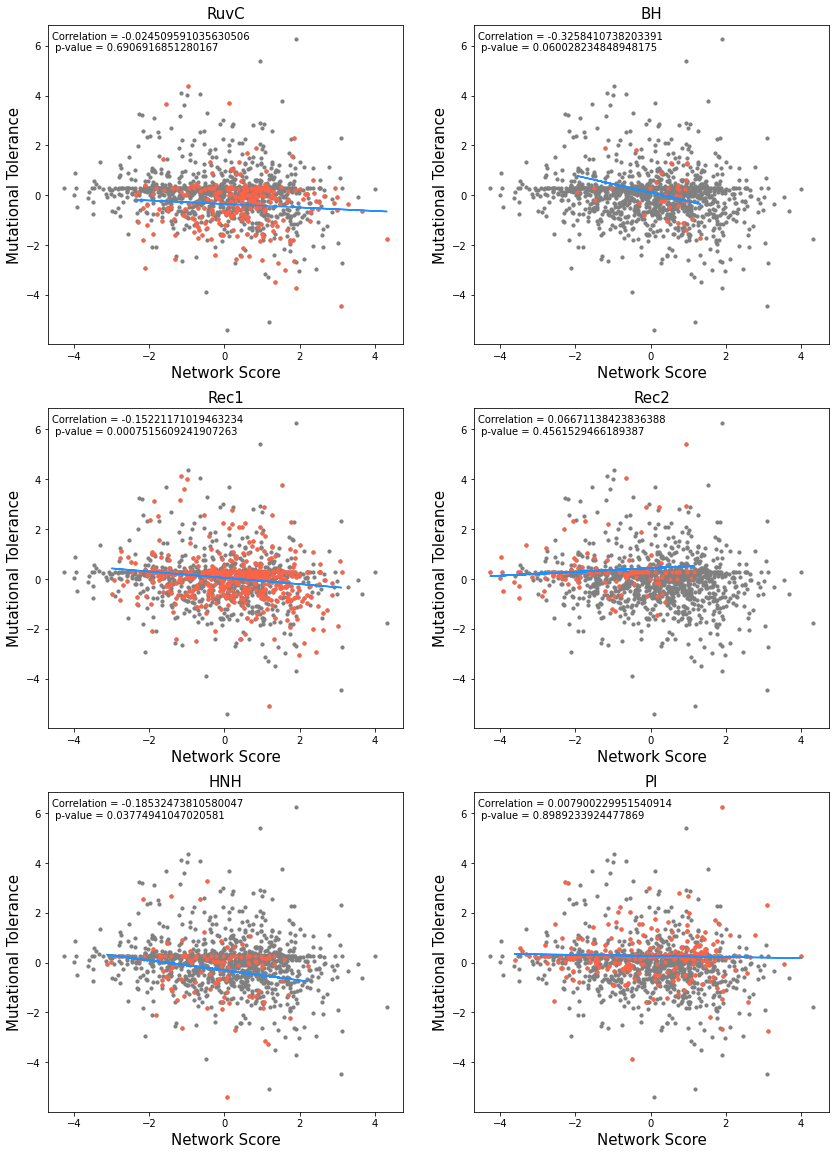

In [10]:
### This section of code is identical to the one that produces a figure ###
### and linear regression for Cas9 network analysis but does so for ###
### each domain on its own. ###

# Generate a figure with six subplots
fig, axs = plt.subplots(3,2, figsize=(14,20))

# RuvC plotting 
axs[0,0].scatter(x_vals, y_vals, s=10, color='grey')
axs[0,0].scatter(RuvC_x_vals, RuvC_y_vals, s=10, color='tomato')
m, b = np.polyfit(RuvC_x_vals, RuvC_y_vals, 1)
axs[0,0].plot(RuvC_x_vals, m*RuvC_x_vals + b, color='dodgerblue')
axs[0,0].set_xlabel('Network Score', fontsize=15)
axs[0,0].set_ylabel('Mutational Tolerance', fontsize=15)
axs[0,0].set_title('RuvC', fontsize=15)

# RuvC statistics
model_x = np.array(RuvC_x_vals).reshape((-1,1))
model_y = np.array(RuvC_y_vals)
correlation, pvalue = stats.spearmanr(model_x, model_y)

# To generate legends on subplots, mpatches package was used since
# plt functions were not appropriate for subplots
spearman_patch = mpatches.Patch(facecolor='None',
                                label='Correlation = {} \n p-value = {}'.
                                format(correlation,pvalue))
axs[0,0].legend(loc=[-0.08,0.9], handles=[spearman_patch], frameon=False, 
                fontsize=10)

# BH plotting
axs[0,1].scatter(x_vals, y_vals, s=10, color='grey')
axs[0,1].scatter(BH_x_vals, BH_y_vals, s=10, color='tomato')
m, b = np.polyfit(BH_x_vals, BH_y_vals, 1)
axs[0,1].plot(BH_x_vals, m*BH_x_vals + b, color='dodgerblue')
axs[0,1].set_xlabel('Network Score', fontsize=15)
axs[0,1].set_ylabel('Mutational Tolerance', fontsize=15)
axs[0,1].set_title('BH', fontsize=15)

# BH statistics
model_x = np.array(BH_x_vals).reshape((-1,1))
model_y = np.array(BH_y_vals)
correlation, pvalue = stats.spearmanr(model_x, model_y)
spearman_patch = mpatches.Patch(facecolor='None',
                                label=
                                'Correlation = {} \n p-value = {}'.
                                format(correlation,pvalue))
axs[0,1].legend(loc=[-0.08,0.9], handles=[spearman_patch], frameon=False,
                fontsize=10)

# Rec1 plotting
axs[1,0].scatter(x_vals, y_vals, s=10, color='grey')
axs[1,0].scatter(Rec1_x_vals, Rec1_y_vals, s=10, color='tomato')
m, b = np.polyfit(Rec1_x_vals, Rec1_y_vals, 1)
axs[1,0].plot(Rec1_x_vals, m*Rec1_x_vals + b, color='dodgerblue')
axs[1,0].set_xlabel('Network Score', fontsize=15)
axs[1,0].set_ylabel('Mutational Tolerance', fontsize=15)
axs[1,0].set_title('Rec1', fontsize=15)

# Rec1 statistics
model_x = np.array(Rec1_x_vals).reshape((-1,1))
model_y = np.array(Rec1_y_vals)
correlation, pvalue = stats.spearmanr(model_x, model_y)
spearman_patch = mpatches.Patch(facecolor='None',
                                label='Correlation = {} \n p-value = {}'.
                                format(correlation,pvalue))
axs[1,0].legend(loc=[-0.08,0.9], handles=[spearman_patch], frameon=False, 
                fontsize=10)

# Rec2 plotting
axs[1,1].scatter(x_vals, y_vals, s=10, color='grey')
axs[1,1].scatter(Rec2_x_vals, Rec2_y_vals, s=10, color='tomato')
m, b = np.polyfit(Rec2_x_vals, Rec2_y_vals, 1)
axs[1,1].plot(Rec2_x_vals, m*Rec2_x_vals + b, color='dodgerblue')
axs[1,1].set_xlabel('Network Score', fontsize=15)
axs[1,1].set_ylabel('Mutational Tolerance', fontsize=15)
axs[1,1].set_title('Rec2', fontsize=15)

# Rec2 statistics
model_x = np.array(Rec2_x_vals).reshape((-1,1))
model_y = np.array(Rec2_y_vals)
correlation, pvalue = stats.spearmanr(model_x, model_y)
spearman_patch = mpatches.Patch(facecolor='None',
                                label='Correlation = {} \n p-value = {}'.
                                format(correlation,pvalue))
axs[1,1].legend(loc=[-0.08,0.9], handles=[spearman_patch], frameon=False, 
                fontsize=10)

# HNH plotting
axs[2,0].scatter(x_vals, y_vals, s=10, color='grey')
axs[2,0].scatter(HNH_x_vals, HNH_y_vals, s=10, color='tomato')
m, b = np.polyfit(HNH_x_vals, HNH_y_vals, 1)
axs[2,0].plot(HNH_x_vals, m*HNH_x_vals + b, color='dodgerblue')
axs[2,0].set_xlabel('Network Score', fontsize=15)
axs[2,0].set_ylabel('Mutational Tolerance', fontsize=15)
axs[2,0].set_title('HNH', fontsize=15)

# HNH statistics
model_x = np.array(HNH_x_vals).reshape((-1,1))
model_y = np.array(HNH_y_vals)
correlation, pvalue = stats.spearmanr(model_x, model_y)
spearman_patch = mpatches.Patch(facecolor='None',
                                label='Correlation = {} \n p-value = {}'.
                                format(correlation,pvalue))
axs[2,0].legend(loc=[-0.08,0.9],handles=[spearman_patch], frameon=False, 
                fontsize=10)

# PI plotting
axs[2,1].scatter(x_vals, y_vals, s=10, color='grey')
axs[2,1].scatter(PI_x_vals, PI_y_vals, s=10, color='tomato')
m, b = np.polyfit(PI_x_vals, PI_y_vals, 1)
axs[2,1].plot(PI_x_vals, m*PI_x_vals + b, color='dodgerblue')
axs[2,1].set_xlabel('Network Score', fontsize=15)
axs[2,1].set_ylabel('Mutational Tolerance', fontsize=15)
axs[2,1].set_title('PI', fontsize=15)

# PI statistics
model_x = np.array(PI_x_vals).reshape((-1,1))
model_y = np.array(PI_y_vals)
correlation, pvalue = stats.spearmanr(model_x, model_y)
spearman_patch = mpatches.Patch(facecolor='None',
                                label='Correlation = {} \n p-value = {}'.
                                format(correlation,pvalue))
axs[2,1].legend(loc=[-0.08,0.90], handles=[spearman_patch], frameon=False, 
                fontsize=10)

plt.show()

# Save plots to a jpg
fig.savefig('Structural Network Analysis by Domain.jpg', bbox_inches='tight')